In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import print_function

import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from astroML.utils import split_samples, completeness_contamination

# Exercise 1

### 1.1

In [227]:
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        headers = next(csv_reader)
        data = {header: [] for header in headers}
        
        for row in csv_reader:
            count = 0
            for header, value in zip(headers, row):
                if count != 5:
                    data[header].append(float(value))
                else:
                    data[header].append(value)
                count += 1
                
                
    return headers, data

# Example usage
file_path = '/Users/user1/Desktop/School/Masters/Computational Physics/galaxyquasar.csv'
names, data = read_csv_file(file_path)

print(names)
print(data[names[5]])


['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']
['QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GALAXY', 'QSO', 'GALAXY', 'QSO', 'QSO', 'GALAXY', 'GALAXY', 'GALAXY', 'GA

In [228]:
u_g = np.array(data[names[0]])-np.array(data[names[1]])
g_r = np.array(data[names[1]])-np.array(data[names[2]])
r_i = np.array(data[names[2]])-np.array(data[names[3]])
i_z = np.array(data[names[3]])-np.array(data[names[4]])

labels = []
for i in range(len(data[names[5]])):
    if data[names[5]][i] == 'GALAXY':
        labels.append(0)
    else:
        labels.append(1)    

### 1.2 + 1.3

In [229]:
X = np.column_stack((u_g, g_r, r_i,i_z))
y = np.array(labels)
print(X.shape)

(50000, 4)


GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


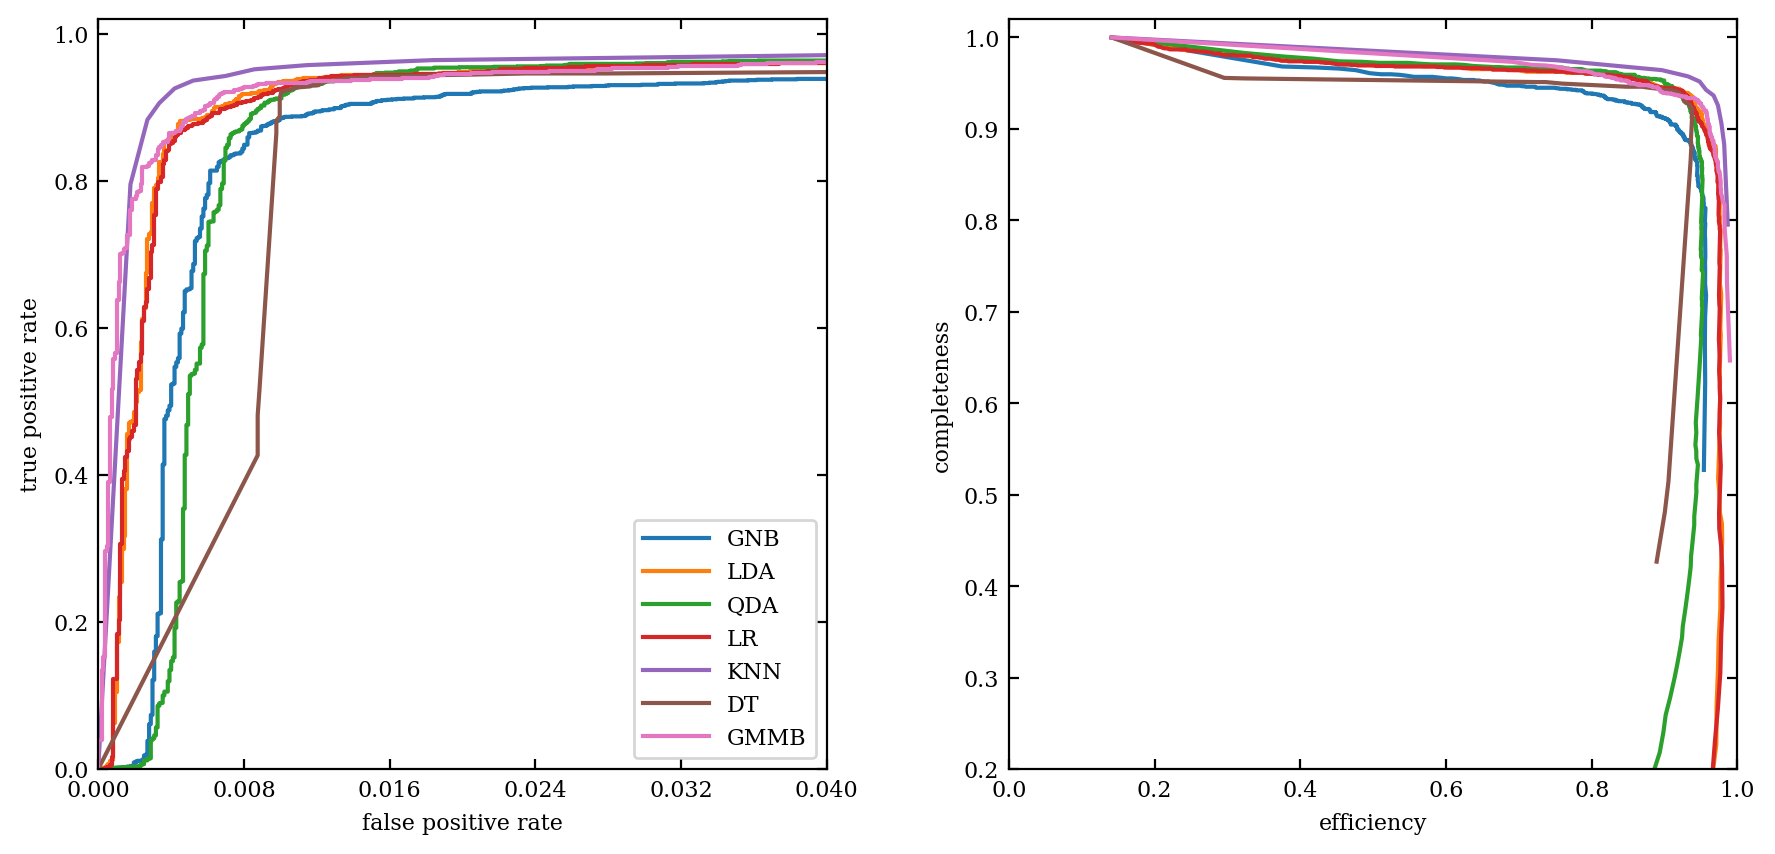

In [230]:
y = y.astype(int)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)


#------------------------------------------------------------
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                             covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

# ax3 will show precision/recall
# ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)


plt.show()

### 1.4

completeness [0.00510204 0.20294785 0.7329932  0.91609977]
contamination [0.82692308 0.1536643  0.12694126 0.11159978]


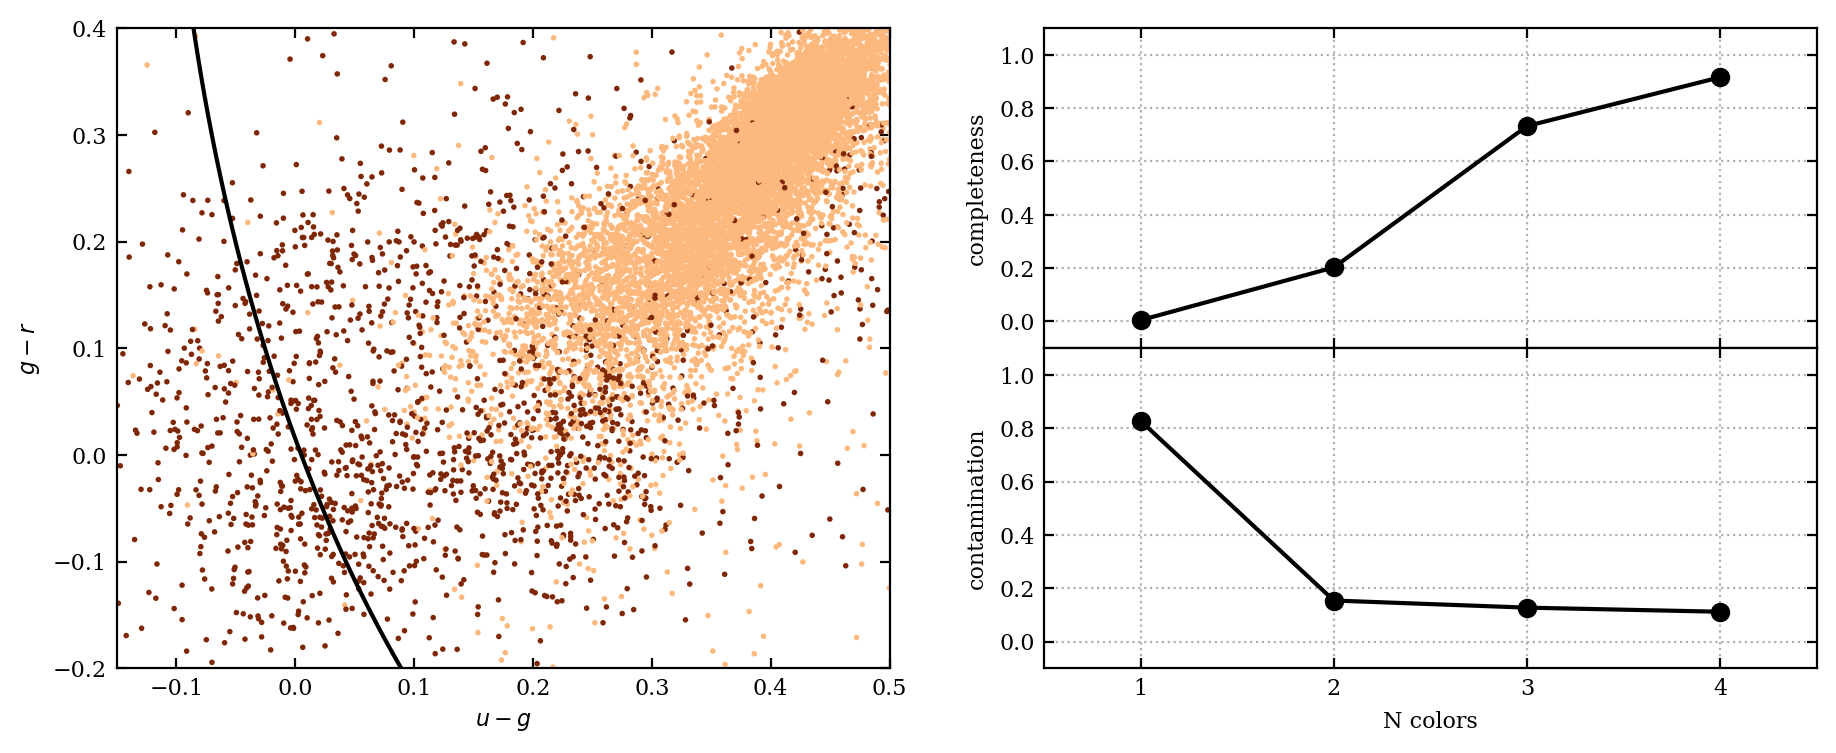

In [250]:
# # Ivezic v2, Figure 9.8, edits by SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
Xnew, ynew = X, y
Xnew = Xnew[:, [3, 2, 1, 0]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(Xnew, ynew, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(ynew)
N_st = np.sum(ynew == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, Xnew.shape[1] + 1)

for nc in Ncolors:
    clf = GaussianNB()
    #clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
#xlim = (-0.5, 1) # boundaries for the regular order [0,1,2,3]
#ylim = (-0.15, 2) # boundaries for the regular order [0,1,2,3]
xlim = (-0.15,0.5)
ylim = (-0.2,0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(Xnew[-N_plot:, 1], Xnew[-N_plot:, 0], c=ynew[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

For the most important feature, we'll order the data in different ways and look for a substantial increase in the completeness plot as we add more colors.

For the ordering [1, 3, 2, 0] = g-r, i-z, r-i, u-g we can see this increase, so it means that u-g is an important feature!

Trying different orderings we get - **the most important feature is u-g and then g-r.**

### 1.5

For this we'll look for different orderings which have a substantial increase or decrease in the completeness and contamination plots - which suggests invalidating the independence assumption.

For example - features i-z and r-i are probably correlated or dependent features.

# Exercise 2

In [225]:
import h5py

file = h5py.File('/Users/user1/Downloads/sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

mtot = file['mtot'][()]
q = file['q'][()]
z = file['z'][()]
psi = file['psi'][()]
ra = file['ra'][()]
dec = file['dec'][()]
iota = file['iota'][()]

det = file['det'][()]

file.close()

In [226]:
from sklearn.ensemble import RandomForestClassifier
from astroML.classification import GMMBayes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


# Downsample the data
downsample_size = 100000
indices = np.random.choice(range(len(mtot)), size=downsample_size, replace=False)
mtot = mtot[indices]
q = q[indices]
z = z[indices]
psi = psi[indices]
ra = ra[indices]
dec = dec[indices]
iota = iota[indices]
det = det[indices]

X = np.column_stack((mtot, q, z, psi, ra, dec ,iota))
y = det

(X_train, X_val), (y_train, y_val) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=42)

#clf = QDA()
#clf = GMMBayes(3)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

completeness, contamination = completeness_contamination(y_pred, y_val)


print("Completeness:", completeness)
print("Contamination:", contamination)


Completeness: 0.8644808743169399
Contamination: 0.10797857344234564


I chose to use only some of the features (the ones related to mass and redshift) and downsample the data (since not downsampling it didnt' change the results much and took a lot more time).

Tried different samplers and found the best to be Random Forest, although GMMBayes and QDA also were in the top 3.

GMMBayes - higher completeness (around 0.85) but higher contamination (around 0.2).
QDA - higher completeness (around 0.87) but higher contamination (around 0.27).
RandomForest - best balance between the two quantities. completeness 0.78, contamination 0.15.


After further consideration I added more features and got better result.